In [170]:
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from utils import zeroPadFront, get_terminology
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib as mpl

In [171]:
class SPL_Terms:
    def __init__(self, path="./"):
        self.color = get_terminology(path + "/color.xml")
        self.color.set_index("code", inplace=True)
        self.shape = get_terminology(path + "/shape.xml")
        self.shape.set_index("code", inplace=True)

    def translateColorCode(self, spl_codes):
        if not spl_codes:
            return []
        return [self.color.loc[c]["name"] for c in spl_codes]
    
    def translateShapeCode(self, spl_codes):
        if not spl_codes:
            return []
        return [self.color.loc[c]["name"] for c in spl_codes]

spl_terms = SPL_Terms()

def getMarker(color):
    if not color:
        return {'marker':'.', 'markersize':10, 'color':'black'}
    elif len(color) == 1:
        return {'marker':'o', 'markersize':10, 'color':color[0], 'markeredgecolor':'black'}
    else:
        return {'marker':'o', 'markersize':10, 'fillstyle':'left', 'color':color[0], 'markerfacecoloralt':color[1], 'markeredgecolor':'black'}
    
def loadImages(paths):
    return np.stack(paths.map(Image.open))

def normalize(images):
    mean = np.mean(images, axis=(0,1,2))
    std = np.std(images, axis=(0,1,2))
    return (images-mean)/std

def encodeImages(image_paths, model):
    #load and normalize images
    images = normalize(np.stack(image_paths.map(Image.open)))

    #convert to tensor and change dimensions to (n,c,w,h)
    images = torch.Tensor(images).permute(dims=(0,3,1,2))

    with torch.no_grad():
        encodings=model(images)
    
    return encodings

format_ndc = lambda label_code, product_code: zeroPadFront(label_code, 5) + '-' + zeroPadFront(product_code, 4)

def plotClusters(x, labels, center, path="./cluster_plots"):
    n = len(labels)
    k = len(center)
    colors = list(mpl.colors.XKCD_COLORS.keys())[0:n]
    plt.scatter(x[:, 0], x[:, 1], c=list(map(lambda i: colors[i], labels)), s=10)
    plt.scatter(center[:, 0], center[:, 1], c='red', s=200, marker='X', label='Centroids')
    plt.title("k=" + str(k))
    plt.savefig(path + "/k=" + str(k) + ".png")
    plt.close()


def kmeans_elbow_plot(encodings, start_k, max_k=None, plot_clusters=False):
    if not max_k:
        max_k = start_k
    wcss=[]
    for k in range(start_k, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        labels = kmeans.fit_predict(encodings)
        center = kmeans.cluster_centers_
        wcss.append(kmeans.inertia_)
        if plot_clusters:
            plot_clusters(k, encodings, labels, center)
    
    plt.plot(np.arange(start_k, max_k), wcss, marker="o")
    plt.title("Elbow Plot")
    plt.xlabel("k values")
    plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
    plt.savefig("elbow_plot.png")
    plt.show()

In [ ]:
all_labels = pd.read_csv("./datasets/ePillID_data/all_labels.csv")
format_ndc = lambda label_code, product_code: zeroPadFront(label_code, 5) + '-' + zeroPadFront(product_code, 4)
codes = all_labels.apply(lambda x: format_ndc(x['label_code_id'], x['prod_code_id']), axis=1)
all_labels['NDC'] = codes

properties = pd.read_json("ePillId_properties.json")
properties["NDC"] = properties["NDC"].map(lambda x: format_ndc(x.split("-")[0], x.split("-")[1]))
properties.set_index("NDC", inplace=True)
properties["marker"] = properties["COLOR"].str.split(";").map(lambda c: getMarker(spl_terms.translateColorCode(c)))

all_labels_properties = all_labels.join(properties, on="NDC", how="left")
segmented_nih_pills = all_labels_properties[all_labels_properties["image_path"].str.startswith("segmented_nih_pills_224")]


In [ ]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)

#peel off last layer
model.fc = torch.nn.Identity() 

In [164]:
import random
dir_path = "./datasets/ePillId_data/classification_data/"
rand_sample = segmented_nih_pills.loc[random.sample(segmented_nih_pills.index.to_list(), 100)]
rand_sample["image_path"] = rand_sample["image_path"].map(lambda x: dir_path + x)
rand_sample["encoding"] = encodeImages(rand_sample["image_path"], model).tolist()

In [177]:
pca = PCA(2)
reduced_encodings = pca.fit_transform(np.stack(rand_sample["encoding"].values))
rand_sample["reduced_encoding"] = reduced_encodings.tolist()

for group in rand_sample.groupby("COLOR"):
    marker_style = getMarker(spl_terms.translateColorCode(group[0].split(";")))
    data = np.stack(group[1]["reduced_encodings"].values)
    plt.plot(data[:,0], data[:,1], linestyle="None", **marker_style)
plt.title("2D Image Encodings") 
plt.savefig("./2D_Image_Encodings.png")
plt.close()

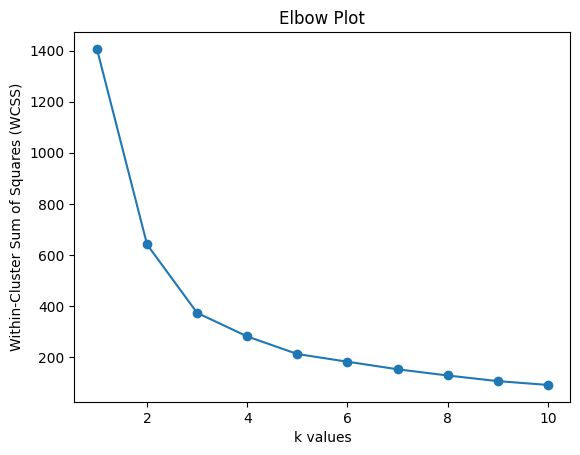

In [178]:
start_k = 1
max_k = 10
wcss=[]
encodings = np.stack(rand_sample["reduced_encoding"].values)
for k in range(start_k, max_k+1):
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(encodings)
    center = kmeans.cluster_centers_
    wcss.append(kmeans.inertia_)
    n = len(labels)
    k = len(center)
    colors = list(mpl.colors.XKCD_COLORS.keys())[0:n]
    plt.scatter(encodings[:, 0], encodings[:, 1], c=list(map(lambda i: colors[i], labels)), s=10)
    plt.scatter(center[:, 0], center[:, 1], c='red', s=200, marker='X', label='Centroids')
    plt.title("k=" + str(k))
    plt.savefig("./cluster_plots" + "/k=" + str(k) + ".png")
    plt.close()

plt.plot(np.arange(start_k, max_k+1), wcss, marker="o")
plt.title("Elbow Plot")
plt.xlabel("k values")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.savefig("elbow_plot.png")
plt.show()